In [13]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    

In [14]:

# Define dataset path and categories
DATADIR = '/Users/sivaluxan/Documents/AI/MLP/Project/FireNet-LightWeight-Network-for-Fire-Detection/Training Dataset'
CATEGORIES = ['Fire', 'NoFire']
IMG_SIZE = 64

def create_training_data():
    training_data = []
    for category in CATEGORIES:  
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass
    return training_data

# Load and preprocess data
training_data = create_training_data()
X, Y = [], []
for features, label in training_data:
    X.append(features)
    Y.append(label)

# Normalize the data
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255.0
Y = np.array(Y)
    

100%|██████████████████████████████████████| 1301/1301 [00:06<00:00, 195.91it/s]


In [15]:

# Split dataset into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)
    

In [16]:

# Apply data augmentation only to training data
train_datagen = ImageDataGenerator(
    rotation_range=20,  # Reduced from 30
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],  # More stable range
    zoom_range=0.2,  # Reduced from 0.3
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator()  # No augmentation for validation

# Create generators
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=32)
    

In [17]:
# CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [18]:

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),  # Increased from 0.0005
              metrics=['accuracy'])

In [19]:
import numpy as np

X = np.array(X)
Y = np.array(Y)

# Callbacks for better training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train upgraded model
history = model.fit(
    X, Y,
    batch_size=32,
    epochs=100,
    validation_split=0.3,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/100
53/53 - 4s - loss: 1.6527 - accuracy: 0.7017 - val_loss: 1.5548 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 4s/epoch - 72ms/step
Epoch 2/100
53/53 - 3s - loss: 0.4854 - accuracy: 0.7954 - val_loss: 1.3474 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 3s/epoch - 55ms/step
Epoch 3/100
53/53 - 3s - loss: 0.4285 - accuracy: 0.8213 - val_loss: 2.1570 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 3s/epoch - 54ms/step
Epoch 4/100
53/53 - 3s - loss: 0.3698 - accuracy: 0.8449 - val_loss: 2.0971 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 3s/epoch - 54ms/step
Epoch 5/100
53/53 - 3s - loss: 0.3579 - accuracy: 0.8402 - val_loss: 2.1773 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 3s/epoch - 55ms/step
Epoch 6/100
53/53 - 3s - loss: 0.3346 - accuracy: 0.8550 - val_loss: 2.1816 - val_accuracy: 0.0014 - lr: 0.0010 - 3s/epoch - 56ms/step
Epoch 7/100

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
53/53 - 3s - loss: 0.3166 - accuracy: 0.8662 - val_loss: 2.2515 - val_accuracy: 0

In [23]:

# Save the trained model
model.save('/Users/sivaluxan/Documents/AI/MLP/Project/FireNet-LightWeight-Network-for-Fire-Detection/Trained_Model_FIreNet/Fire-detection-optimized-v2.h5')
    

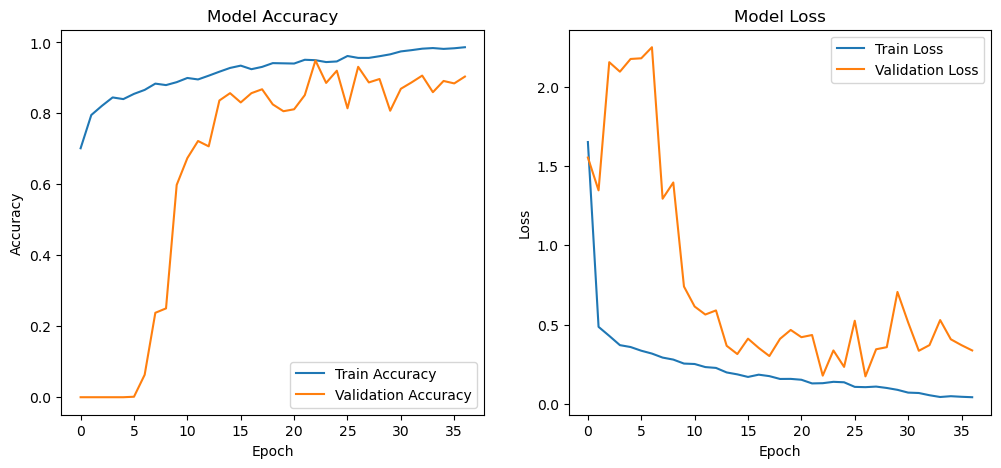

In [24]:

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

    

In [25]:

# Print final accuracy
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    

Final Training Accuracy: 0.9864
Final Validation Accuracy: 0.9037
